In [2]:
import csv
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

tf.random.set_seed(51)
np.random.seed(51)
print(tf.__version__)

2.0.0-alpha0


In [54]:
import csv
time_steps = []
prices = []

with open('TSLA.csv') as csvfile:
    reader = csv.reader(csvfile, delimiter=',')
    
    next(reader) #Jump the header
    
    for raw in reader:
        time_steps.append(raw[0])
        prices.append(float(raw[1]))
prices = np.array(prices)
time = np.array(time_step)
time = np.arange(len(prices))

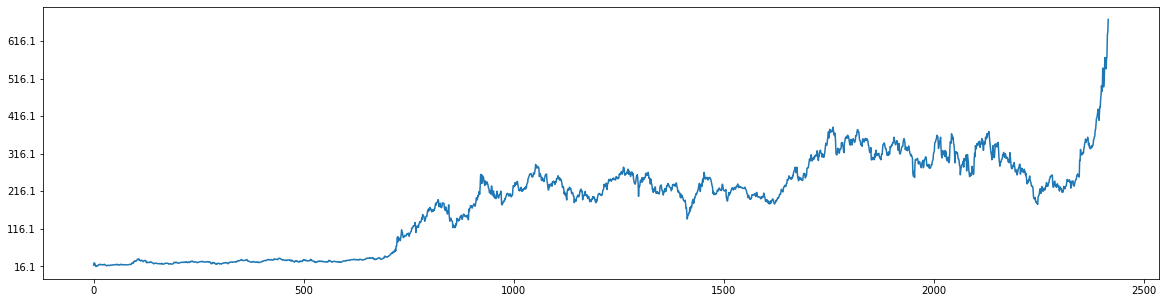

In [51]:
plt.figure(figsize=(20,5))
plt.yticks(np.arange(min(prices), max(prices),100))
plt.plot(time, prices)

In [55]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
        """
        window_size : Number of features (past occurences)
        batch_size : Number of sequences in a batch
        shuffle_buffer : size of the buffer
        """
        dataset = tf.data.Dataset.from_tensor_slices(series)
        dataset = dataset.window(window_size + 1, shift=1, drop_remainder=True)
        dataset = dataset.flat_map(lambda window: window.batch(window_size + 1))
        dataset = dataset.shuffle(shuffle_buffer).map(lambda window: (window[:-1], window[-1]))
        dataset = dataset.batch(batch_size).prefetch(1)
        return dataset

In [56]:
split_time = 2000
time_train = time[:split_time]
x_train = prices[:split_time]
time_valid = time[split_time:]
x_valid = prices[split_time:]

window_size = 10
batch_size = 32
shuffle_buffer_size = 2000

In [57]:
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)
print(dataset)
l0 = tf.keras.layers.Dense(1, input_shape=[window_size])
model = tf.keras.models.Sequential([l0])


model.compile(loss="mse", optimizer=tf.keras.optimizers.SGD(lr=1e-6, momentum=0.9))
history=model.fit(dataset,epochs=200,verbose=1)

print("Layer weights {}".format(l0.get_weights()))


<PrefetchDataset shapes: ((None, None), (None,)), types: (tf.float64, tf.float64)>
Epoch 1/200
63/63 [==============================] - 1s 9ms/step - loss: 29072.4812
Epoch 2/200
63/63 [==============================] - 0s 4ms/step - loss: 349.1020
Epoch 3/200
63/63 [==============================] - 0s 4ms/step - loss: 179.4593
Epoch 4/200
63/63 [==============================] - 0s 4ms/step - loss: 142.0895
Epoch 5/200
63/63 [==============================] - 0s 3ms/step - loss: 118.0330
Epoch 6/200
63/63 [==============================] - 0s 4ms/step - loss: 102.0090
Epoch 7/200
63/63 [==============================] - 0s 4ms/step - loss: 90.7727
Epoch 8/200
63/63 [==============================] - 0s 4ms/step - loss: 82.5422
Epoch 9/200
63/63 [==============================] - 0s 4ms/step - loss: 76.3075
Epoch 10/200
63/63 [==============================] - 0s 3ms/step - loss: 71.4668
Epoch 11/200
63/63 [==============================] - 0s 3ms/step - loss: 67.6408
Epoch 12/200
63/

63/63 [==============================] - 0s 4ms/step - loss: 41.3266
Epoch 100/200
63/63 [==============================] - 0s 4ms/step - loss: 41.2785
Epoch 101/200
63/63 [==============================] - 0s 4ms/step - loss: 41.2316
Epoch 102/200
63/63 [==============================] - 0s 4ms/step - loss: 41.1857
Epoch 103/200
63/63 [==============================] - 0s 4ms/step - loss: 41.1411
Epoch 104/200
63/63 [==============================] - 0s 4ms/step - loss: 41.0974
Epoch 105/200
63/63 [==============================] - 0s 4ms/step - loss: 41.0547
Epoch 106/200
63/63 [==============================] - 0s 4ms/step - loss: 41.0130
Epoch 107/200
63/63 [==============================] - 0s 4ms/step - loss: 40.9725
Epoch 108/200
63/63 [==============================] - 0s 4ms/step - loss: 40.9327
Epoch 109/200
63/63 [==============================] - 0s 4ms/step - loss: 40.8940
Epoch 110/200
63/63 [==============================] - 0s 4ms/step - loss: 40.8562
Epoch 111/200
63/6

63/63 [==============================] - 0s 3ms/step - loss: 39.4042
Epoch 198/200
63/63 [==============================] - 0s 4ms/step - loss: 39.3979
Epoch 199/200
63/63 [==============================] - 0s 4ms/step - loss: 39.3918
Epoch 200/200
63/63 [==============================] - 0s 4ms/step - loss: 39.3857
Layer weights [array([[ 0.01354541],
       [-0.00403096],
       [-0.0429497 ],
       [-0.00111502],
       [ 0.05767399],
       [-0.00512948],
       [ 0.02327778],
       [-0.02374232],
       [ 0.04791588],
       [ 0.94047904]], dtype=float32), array([0.02922347], dtype=float32)]


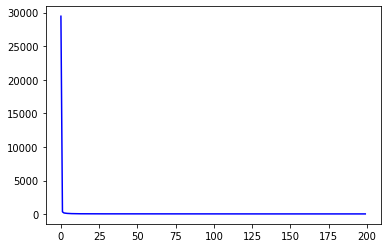

In [58]:
loss = history.history['loss']
epochs = range(len(loss))
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.show()

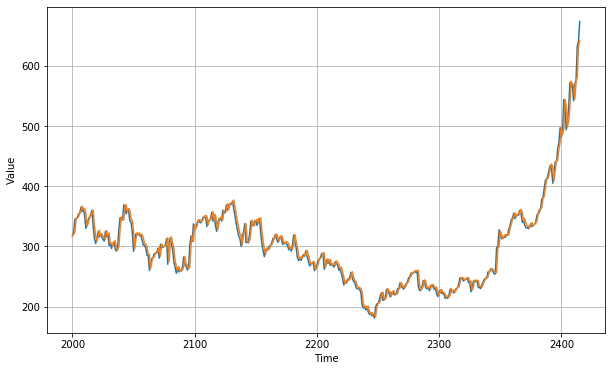

In [59]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)
    
forecast = []

for time in range(len(prices) - window_size):
    forecast.append(model.predict(prices[time:time + window_size][np.newaxis]))

forecast = forecast[split_time-window_size:]
results = np.array(forecast)[:, 0, 0]


plt.figure(figsize=(10, 6))

plot_series(time_valid, x_valid)
plot_series(time_valid, results)

In [61]:
model.predict(prices[1990:2000][np.newaxis])

array([[317.01624]], dtype=float32)

In [62]:
prices[2001]

322.51001